# GF-KSD: Convergence Detection (Figure 1)

Here we evaluate the ability of the gradient-free KSD to detect convergence to a target distribution.

Taking the target distribution to a bimodal Gaussian mixture, we generate six sequences of distributions, of which three are constructed to converge to the target distribution, and the other three are constructed to converge to a different distribution (specifically a simple Gaussian). We expect KSD to detect convergence for the first three sequences and detect a lack of convergence for the other three.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib.colors import LinearSegmentedColormap

from colour import Color

import torch
import torch.distributions as D

from pylab import rcParams

from steintorch.distribution.base import Distribution
from steintorch.divergence.ksd import GradientFreeKSD
from steintorch.kernel import SquaredExponentialKernel
from steintorch.utils.cdf import get_1D_mixture_cdf, get_icdf
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from steintorch.utils.get_score import get_score

In [2]:
style.use("seaborn-v0_8-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = 10,6

In [3]:
torch.manual_seed(3);

### Define target distribution

We take the target distribution to be a Gaussian mixture with three components:

In [4]:
weights = torch.Tensor([0.6, 0.9, 0.1])
mean_vec = torch.Tensor([[-0.4], [0.3], [0.06]])
var_vec = torch.Tensor([[0.2], [0.2], [0.9]])

mix = D.Categorical(weights)
normal = D.Normal(mean_vec, var_vec)
comp = D.Independent(normal, 1)
P = D.MixtureSameFamily(mix, comp)
P.cdf = get_1D_mixture_cdf(normal,weights)  # make the target P have a well defined CDF

## Defining Sequences

A helper function to apply a location-scale transformation to a given distribution:

In [5]:
def transform_distribution(location, scale, target_dist=P):
    """
    Apply location-scale transformation to a distribution
    """
    transformed_distribution = Distribution()

    def sample_Q_n(n=None, samps=None):
        if samps is None:
            return target_dist.sample(n) * scale + location
        else:
            return samps * scale + location

    def log_prob_Q_n(x):
        return target_dist.log_prob((x - location) / scale) - torch.log(scale)

    def cdf_Q_n(x):
        return target_dist.cdf((x - location) / scale)

    icdf_Q_n = get_icdf(cdf_Q_n, log_prob=log_prob_Q_n)

    transformed_distribution.sample = sample_Q_n
    transformed_distribution.log_prob = log_prob_Q_n
    transformed_distribution.cdf = cdf_Q_n
    transformed_distribution.icdf = icdf_Q_n

    return transformed_distribution

Helper function to generate sequences of scale and location parameters:

In [6]:
def phi_increasing_scale(n):
    return torch.Tensor([0]), torch.Tensor([1 - 1 / (n + 1.9)])

def phi_decreasing_scale(n):
    return torch.Tensor([0]), torch.Tensor([1 + 2 / (n + 1)])

def phi_decreasing_location(n):
    return torch.Tensor([5 / (n + 4)]), torch.Tensor([1])

def phi_mix(n):
    return (
        torch.Tensor([-5 / (n + 4) ** 1.5]),
        torch.Tensor([1 + 2 / (n+1) ** 1.5 + torch.sin(torch.Tensor([n])) * 1/(n+1) ** 1.5]),
    )

def phi_linear_increasing_location(n):
    return torch.Tensor([-4 + n / 25]), torch.Tensor([1])

## Defining $q$ and GF-KSD

Gradient-free KSD requires us to select a distribution $q$ for which gradient can be easily computed. Four options are considered in the paper:

   * the prior distribution,
   * the Laplace approximation,
   * a Gaussian mixture,
   * a kernel-density estimator.

Here construct all four distributions.

In [7]:
def make_score_function(distribution):
    """Helper to construct a score function for a given distibution"""
    def score_function(sample):
        return get_score(sample, distribution)
    return score_function

The prior is picked as a simple Gaussian distribution with fixed parameters:

In [8]:
Q_prior = D.Normal(torch.Tensor([0]), torch.Tensor([0.75]))
score_Q_prior = make_score_function(Q_prior)
q_prior = Q_prior.log_prob

We build a Laplace approximation:

In [9]:
Q_laplace = get_laplace_approximation(P, mode=torch.Tensor([0.3]))
score_Q_laplace = make_score_function(Q_laplace)
q_laplace = Q_laplace.log_prob

Gaussian mixture approximation:

In [10]:
P_sample = P.sample((100,))  # sample used to generate approximations

In [11]:
Q_gmm, bic = get_gaussian_mixture_approximation(P_sample, N=2, evaluate="bic")
print("GMM bic: ", bic)
score_Q_gmm = make_score_function(Q_gmm)
q_gmm = Q_gmm.log_prob

GMM bic:  109.97923391059233


KDE approximation:

In [12]:
kde_kernel = SquaredExponentialKernel(dim=1)  # kernel for KDE
Q_kde = get_kernel_density_approximation(P_sample, kde_kernel)
Q_kde.silvermans_rule()
score_Q_kde = make_score_function(Q_kde)
q_kde = Q_kde.log_prob

Obtain the score function and the log-pdf of the target distribution:

In [13]:
score_P = make_score_function(P)
p = P.log_prob

Plot the densities of the target distribution and the four approximations:

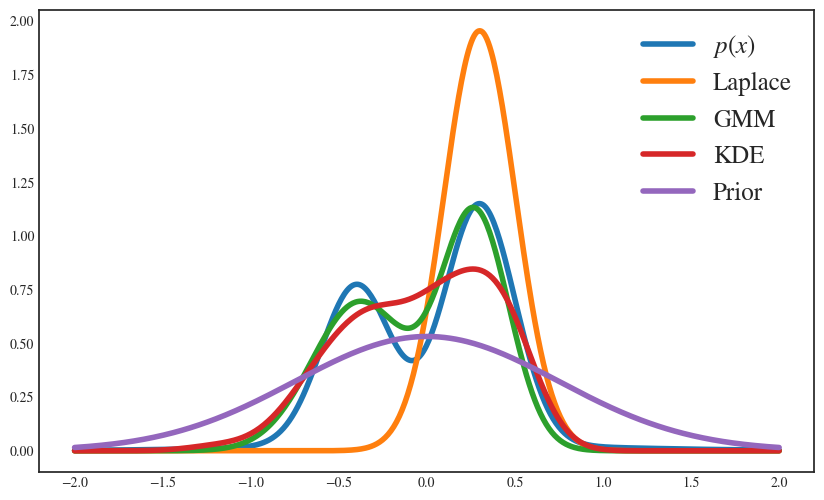

In [14]:
pdfs = [
    ('$p(x)$', p), 
    ('Laplace', q_laplace),
    ('GMM', q_gmm),
    ('KDE', q_kde),
    ('Prior', q_prior),
]

x = torch.linspace(-2, 2, 500)

fig, ax = plt.subplots()

for label, pdf_func in pdfs:
    ax.plot(x, pdf_func(x.unsqueeze(-1)).exp().detach(), linewidth=4, label=label);

ax.legend(prop={'size': 18});

## Plotting Convergence

The number of distributions in each sequence:

In [15]:
N = 100

In [16]:
transformation_parameter_generators = [phi_increasing_scale, phi_decreasing_scale, phi_mix]

### Plot Sequences

Prepar colour palettes to plot sequences of distributions:

In [17]:
colormap_grid = np.linspace(0, 1, N) ** 0.2

def make_colormap(colors): 
    return LinearSegmentedColormap.from_list('my_list', [Color(c).rgb for c in colors])

def plot_colormap(colormap):
    plt.figure(figsize=(15, 3))
    plt.imshow(colormap_grid[np.newaxis, :], interpolation='nearest', origin='lower', cmap=colormap)
    plt.xticks([])
    plt.yticks([])

color_bounds = [
    ('#19040F', '#FF2D96'),
    ('#191100', '#FFB000'),
    ('#0A0E19', '#648FFF'),
]

good_ramps = [make_colormap(bounds) for bounds in color_bounds]

for ramp in good_ramps:
    plot_colormap(ramp)

Produce sequences of distributions converging to the target ``P`` as well as a simple Gaussian distribution

In [18]:
def create_converging_sequences(target, location_scale_generator, N):
    return [transform_distribution(*location_scale_generator(i), target_dist=target) for i in range(N)]

In [19]:
converging_to_target = [
    create_converging_sequences(P, param_generator, N) for param_generator in transformation_parameter_generators
]

other_distribution = D.Normal(torch.Tensor([0]), torch.Tensor([0.5]))
converging_to_other = [
   create_converging_sequences(other_distribution, param_generator, N) for param_generator in transformation_parameter_generators
]

Plot the sequences of distributions:

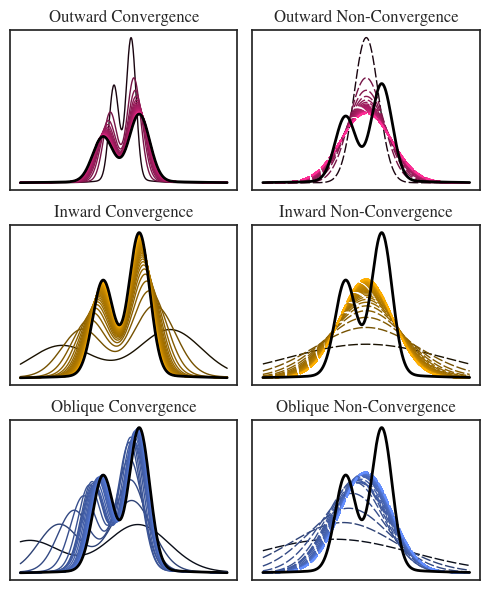

In [20]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(5, 6)

THICKNESS = 1

for j in range(len(converging_to_target)):
    for i in range(len(converging_to_target[j])):
        # sequences converging to the target bimodal mixture
        Q_ij = converging_to_target[j][i]
        axs[j][0].plot(x, Q_ij.log_prob(x.unsqueeze(-1)).exp(), color=good_ramps[j](colormap_grid[i]), linewidth=THICKNESS)

        # sequences converging to a simple Gaussian distribution
        Q_ij = converging_to_other[j][i]
        axs[j][1].plot(x, Q_ij.log_prob(x.unsqueeze(-1)).exp(), color=good_ramps[j](colormap_grid[i]), linewidth=THICKNESS, linestyle='--', dashes=[7, 2])

    axs[j][0].plot(x, P.log_prob(x.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS + 1)
    axs[j][1].plot(x, P.log_prob(x.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS + 1)

axs[0][0].set_title("Outward Convergence")
axs[1][0].set_title("Inward Convergence")
axs[2][0].set_title("Oblique Convergence")

axs[0][1].set_title("Outward Non-Convergence")
axs[1][1].set_title("Inward Non-Convergence")
axs[2][1].set_title("Oblique Non-Convergence")

for i in range(3):
    for j in range(2):
        axs[i][j].xaxis.set_ticks_position('none') 
        axs[i][j].yaxis.set_ticks_position('none') 
        axs[i][j].set_xticklabels([])
        axs[i][j].set_yticklabels([])

fig.tight_layout()

fig.savefig("sequence.pdf", bbox_inches="tight", pad_inches=0)

Calculate discrepancies

In [21]:
gf_KSD = GradientFreeKSD(None)

In [22]:
qs = [
    (q_prior, score_Q_prior),
    (q_laplace, score_Q_laplace),
    (q_gmm, score_Q_gmm),
    (q_kde, score_Q_kde),
    (p, score_P),
]

def calculate_ksd(dist, grid):
    sample = dist.sample(samps=grid).requires_grad_(True) 
    return [gf_KSD.eval(sample, p, q_pdf, q_score).detach() for q_pdf, q_score in qs]

In [23]:
M = 300  # mesh size
uniform_mesh = torch.linspace(0, 1, M + 2)[1:-1]

inverse_cdf_P = get_icdf(P.cdf, log_prob=P.log_prob)
grid = torch.Tensor(inverse_cdf_P(uniform_mesh)).unsqueeze(1)
ksd_converging = np.array([[calculate_ksd(dist, grid) for dist in sequence] for sequence in converging_to_target])

grid = other_distribution.icdf(uniform_mesh).unsqueeze(1)
ksd_non_converging = np.array([[calculate_ksd(dist, grid) for dist in sequence] for sequence in converging_to_other])

/home/artem/git/SteinTorch/src/steintorch/utils/cdf.py:79: RuntimeWarning: some failed to converge after 200 iterations
  vec_res = optimize.newton(func, initial.detach().numpy(), fprime=pdf, fprime2=grad_pdf, args=(x.detach().numpy(),), maxiter=max_iter)


/tmp/ipykernel_1198094/326635532.py:23: RuntimeWarning: invalid value encountered in log
  ax.plot(XX, np.log(ksd_converging[i, :, j]), linewidth=THICKNESS, color=good_ramps[i](value_col))
/tmp/ipykernel_1198094/326635532.py:24: RuntimeWarning: invalid value encountered in log
  ax.plot(XX, np.log(ksd_non_converging[i, :, j]), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle='--', dashes=[7, 2])


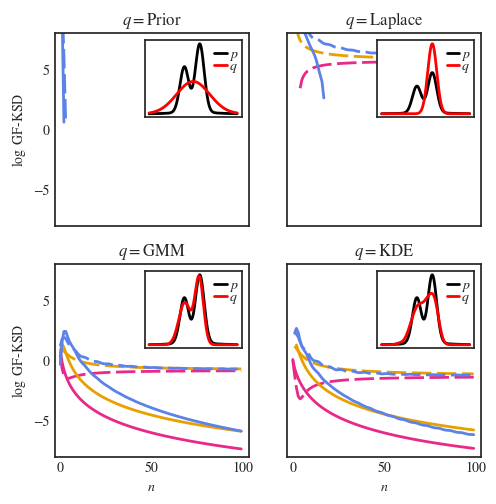

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(5.5, 5.5)

XX = torch.Tensor(list(range(N)))
THICKNESS = 2

value_col = .9

Qs = [
    ('$q=$Prior', Q_prior), 
    ('$q=$Laplace', Q_laplace),
    ('$q=$GMM', Q_gmm),
    ('$q=$KDE', Q_kde),
]

for j in range(4):
    ax = axes[j // 2][j % 2]

    # plot the discrepancies
    for i in range(len(converging_to_target)):
        ax.plot(XX, np.log(ksd_converging[i, :, j]), linewidth=THICKNESS, color=good_ramps[i](value_col))
        ax.plot(XX, np.log(ksd_non_converging[i, :, j]), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle='--', dashes=[7, 2])
        ax.set_title(Qs[j][0])
    
    ax.set_ylim(-8, 8)
    ax.set_xlim(-3, 103)

    # plot the inset
    inset = inset_axes(ax, width='50%', height='40%', loc=1) #prior
    inset.plot(x, P.log_prob(x.unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
    inset.plot(x, Qs[j][1].log_prob(x.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
    inset.legend(loc=1, bbox_to_anchor=(1.095, 1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)
    inset.tick_params(labelleft=False, labelbottom=False)

axes[0][0].xaxis.set_ticklabels([])
axes[0][0].xaxis.set_ticks_position('none') 

axes[0][1].xaxis.set_ticklabels([])
axes[0][1].xaxis.set_ticks_position('none') 

axes[0][1].yaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticks_position('none') 

axes[1][1].yaxis.set_ticklabels([])
axes[1][1].yaxis.set_ticks_position('none') 

axes[0][0].set_ylabel("$\log$ GF-KSD")
axes[1][0].set_ylabel("$\log$ GF-KSD")

axes[1][0].set_xlabel("$n$")
axes[1][1].set_xlabel("$n$")

fig.savefig("ksd_convergence_legend.pdf", bbox_inches="tight", pad_inches=0)

plt.show()